In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
import multiprocessing

import subprocess

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 400e-3
fsm_pupil_diam = 7.0e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


18.652231764916 arcsec
10.48447204968944


<Quantity 1.77903395 arcsec>

In [3]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 50
cam.set_roi(570, 900, npsf, client0)

In [7]:
cam.set_exptime(0.0001, client0)

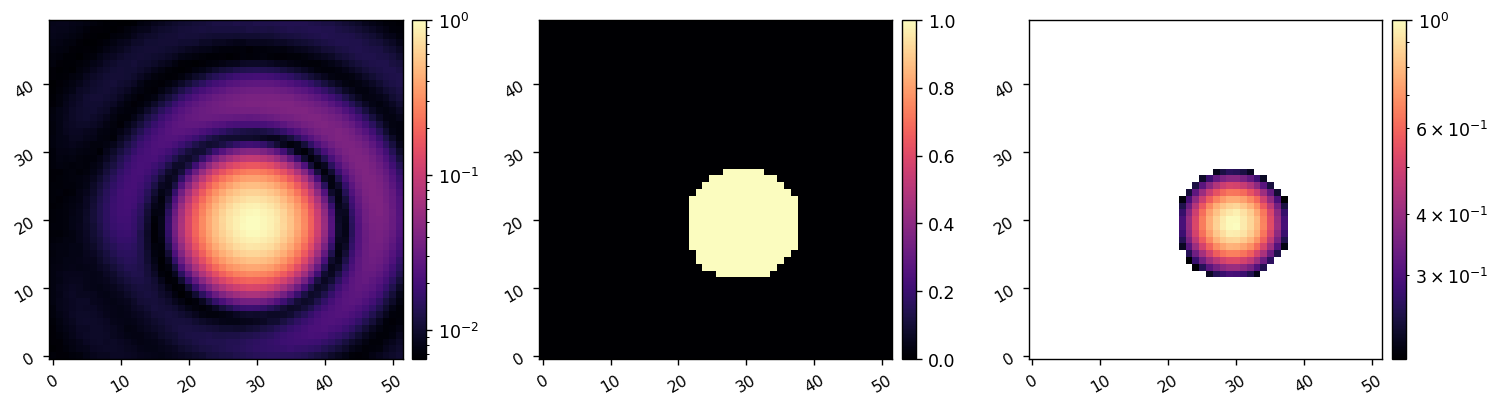

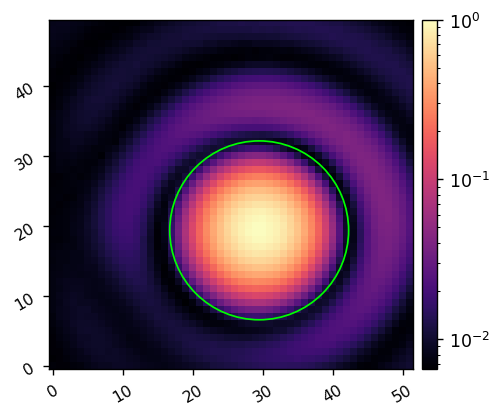

In [18]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup FSM Interface

In [11]:
fsm = ImageStream('fsm')

In [58]:
fsm.write(v_bias)

In [59]:
fsm.write(zero)

# Toggle telem_campupil or telem_fsm to start recording that data.

In [17]:
def toggle_telem_campupil(on=True):
    client0.wait_for_properties(['telem_campupil.writing'])
    if on:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.ON
    else:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.OFF

In [15]:
toggle_telem_campupil(1)
time.sleep(2)
toggle_telem_campupil(0)

In [52]:
3600*24

86400

In [53]:
fnames

['campupil_20250123201032685214788.fits',
 'campupil_20250123201032685741521.fits',
 'campupil_20250123201032686238988.fits',
 'campupil_20250123201032686772606.fits',
 'campupil_20250123201032687271877.fits',
 'campupil_20250123201032687806478.fits',
 'campupil_20250123201032688306027.fits',
 'campupil_20250123201032688824342.fits',
 'campupil_20250123201032689343612.fits',
 'campupil_20250123201032689858585.fits',
 'campupil_20250123201032690375338.fits',
 'campupil_20250123201032690891967.fits',
 'campupil_20250123201032691425681.fits',
 'campupil_20250123201032691925651.fits',
 'campupil_20250123201032692442726.fits',
 'campupil_20250123201032692959879.fits',
 'campupil_20250123201032693480572.fits',
 'campupil_20250123201032694015902.fits',
 'campupil_20250123201032694512026.fits',
 'campupil_20250123201032695028719.fits',
 'campupil_20250123201032695562910.fits',
 'campupil_20250123201032696063047.fits',
 'campupil_20250123201032696585005.fits',
 'campupil_20250123201032697107183

In [51]:
import os

dir_path = "/opt/MagAOX/telem/campupil/out"  # Replace with the actual directory path

fnames = os.listdir(dir_path)
fnames = sorted(fnames)

times = []
for fname in fnames:
    times.append(float(fname[9:-5]))

ValueError: could not convert string to float: ''

In [ ]:
fits.getheader('campupil_20250123203551443875829.fits')

In [50]:
time = fnames[-2][9:-5]
float(time)

2.0250123203552085e+22

In [ ]:
cam_times = []

for i in range()

In [39]:
subprocess.run(['mkdir','/opt/MagAOX/telem/campupil/test-out'])

CompletedProcess(args=['mkdir', '/opt/MagAOX/telem/campupil/test-out'], returncode=0)

In [38]:

subprocess.run(['sudo','xrif2fits','-d','/opt/MagAOX/telem/campupil/','-D','/opt/MagAOX/telem/campupil/out/'])

sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required


CompletedProcess(args=['sudo', 'xrif2fits', '-d', '/opt/MagAOX/telem/campupil/', '-D', '/opt/MagAOX/telem/campupil/out/'], returncode=1)